<h1>Tugas kelompok sisken</h1>
<p>
Anggota:
Nanda Riangga Damanik (19/442385/PA/19134)<br>
Gabriel Possenti (19/442374/PA/19123)<br>
Aziz<br>
Ivander Achmad W. (19/442377/PA/19126)<br>

</p>

In [ ]:
!pip install slycot
!pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 9.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.5.0-cp37-cp37m-linux_x86_64.whl size=2021296 sha256=6b9d8a0f20baf1ad97ce3f430e682ef65ced6852f40883eea452ecae431e988f
  Stored in directory: /root/.cache/pip/wheels/7f/2e/54/e2cb7cf358f956ed0efa9923ab4f5aa353a941422c55b25531
Successfully built slycot
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 398 kB 7.0 MB/s 
  Created wheel for control: filename=control-0.9.2-py2.py3-none-any.whl size=403205 sha256=f381cd2cc15a36939fc5efc273768704c4457221132d0aac23a24b2d42574943
  Stored in directory: /root/.cache/pip/wheels/48/ef/c2/929bb5c59a1328df00a0561d0e68cd7c8537f33f5ce0ce741b
Su

In [ ]:
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import control.matlab as control

def step_info(t,yout):
    print("% overshoot : ",(yout.max()/yout[-1]-1)*100,'%')
    print("Rise time : ",t[next(i for i in range(0,len(yout)-1) if yout[i]>yout[-1]*.90)]-t[0])
    print("%Settling time : ",t[next(len(yout)-i for i in range(2,len(yout)-1) if abs(yout[-i]/yout[-1])>1.02)]-t[0])

s = control.tf('s')
J = 0.01
b = 0.1
K = 0.01
R = 1
L = 0.5

num_motor = [K]
den_motor = [J*L, J*R+b*L, R*b+K*K]

motor = control.tf(num_motor, den_motor)

# Constant
c1=2
c2=2 
w_max = 1 
w_min = 0.1 
particles=50 
iterations=100
var=3 
e_max = 1 
e_min=0.1

# Declaration
v = np.zeros([particles, var])
x = np.zeros([particles, var])
xp = np.zeros([particles, var])
xg = np.zeros([var])
ITAEp = np.zeros([particles])
ITAE = np.zeros([particles])
best_value = np.zeros([999999])


# Search limit
lim_min = 0
lim_max = 2500

# limization steps
steps = 0

# Initialization
for m in range(particles):
    for n in range(var):
        v[m,n]=0
        x[m,n]=lim_min+np.random.rand()*(lim_max-lim_min)
        xp[m,n]=x[m,n]

    # Model Parameters
    Kp = x[m,0]
    Ki = x[m,1]
    Kd = x[m,2]
    # Simulation Model
    pid = control.tf([Kd,Kp,Ki],[0,1,0])
    motor_cl = control.feedback(motor * pid, 1)
    [y,t] = control.step(motor_cl)
    # TIAE (Objective Function)
    total = 0.0
    T = len(y)
    for t in range(T):
        total = total + t*abs(y[t]-1)
    ITAE[m] = total

print(ITAE[0])
print(type(ITAE))

5555.291048537736
<class 'numpy.ndarray'>


In [ ]:
prev_best = min(ITAE)
loc = np.searchsorted(ITAE, min(ITAE))
xg[0] = x[loc,0]
xg[1] = x[loc,1]
xg[2] = x[loc,2]

In [ ]:
for i in range(iterations):
  e = e_max - ((e_max - e_min)*i)/iterations
  w = w_min + ((iterations - i)*(w_max - w_min))/iterations
  for m in range(particles):
    for n in range(var):
      v[m,n] = w*v[m,n] + c1*np.random.rand()*(xp[m,n]-x[m,n]) + c2*np.random.rand()*(xg[n]-x[m,n])
      x[m,n] = x[m,n] + e*v[m,n];
      # Constrain
      if x[m,n] < lim_min:
        x[m,n] = lim_min
      if x[m,n] > lim_max:
        x[m,n] = lim_max
    
    Kp = x[m,0]
    Kp = x[m,1]
    Kp = x[m,2]
    pid = control.tf([Kd, Kp, Ki],[0,1,0])
    motor_cl = control.feedback(motor * pid, 1)
    [y,t] = control.step(motor_cl)

    total = 0
    T = len(y)
    for t in range(T):
      total = total + (t*abs(y[t]-1))
    
    ITAEp[m] = total

    if ITAEp[m] < ITAE[m]:
      ITAE[m] = ITAEp[m]
      xp[m,0] = x[m,0]
      xp[m,1] = x[m,1]
      xp[m,2] = x[m,2]
    

    now_best = min(ITAE)
    loc = np.searchsorted(ITAE, min(ITAE))

    if now_best < prev_best:
      prev_best = now_best
      xg[0] = x[loc,0]
      xg[1] = x[loc,1]
      xg[2] = x[loc,2]
    
    steps = steps + 1
    best_value[steps] = prev_best

In [ ]:
# Final testing
ITAE_min = prev_best
Kp = xg[0]
Ki = xg[1]
Kd = xg[2]

pid = control.tf([Kd, Kp, Ki],[0,1,0])


In [ ]:
motor_cl = control.feedback(motor * pid, 1)
motor_l = control.feedback(motor, 1)



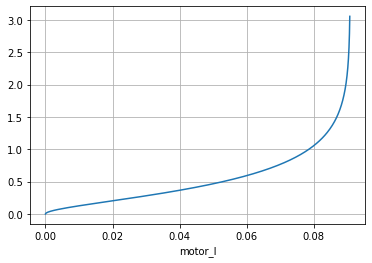

In [ ]:
(t,y) = control.step(motor_l)

plt.plot(t,y)
plt.xlabel('motor_l')
plt.grid()

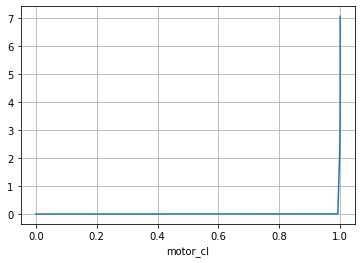

In [ ]:
(t,y) = control.step(motor_cl)

plt.plot(t,y)
plt.xlabel('motor_cl')
plt.grid()

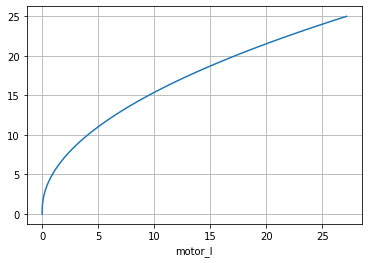

In [ ]:
(t,y) = control.step(motor_l/(s**2))

plt.plot(t,y)
plt.xlabel('motor_l')
plt.grid()

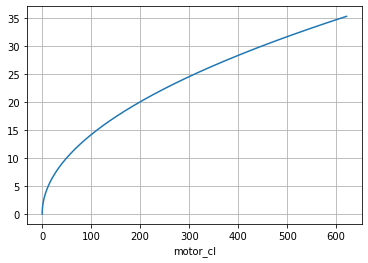

In [ ]:
(t,y) = control.step(motor_cl/(s**2))

plt.plot(t,y)
plt.xlabel('motor_cl')
plt.grid()

In [ ]:
def step_info(t,yout):
    try:
      print("% overshoot : ",(yout.max()/yout[-1]-1)*100,'%')
    except:
      print("% overshoot : -")
    try:
      print("Rise time : ",t[next(i for i in range(0,len(yout)-1) if yout[i]>yout[-1]*.90)]-t[0])
    except:
      print("Rise time : -")
    try:
      print("%Settling time : ",t[next(len(yout)-i for i in range(2,len(yout)-1) if abs(yout[-i]/yout[-1])>1.02)]-t[0])
    except:
      print("%Settling time : -")

y,t = control.step(motor_l)
step_info(t,y)

print("")

y,t = control.step(motor_cl)
step_info(t,y)

% overshoot :  0.0 %
Rise time :  1.1315389526151183
%Settling time : -

% overshoot :  0.002374076125843949 %
Rise time :  0.002821300652605195
%Settling time : -
